In [11]:
import os
import pandas as pd
import webbrowser
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='sriharis', api_key='p8spnf2VsxL5iKxajOu0')

from DataExtractor import DataExtractor
from DataUtils import *
from VizTools import *

In [12]:
# Set the path variables
_path = os.path.join(os.getcwd(), "datasets/crime")

db = 'crime_data'

start_year = 2015
end_year = 2017
all_year_data = []

columns_to_select = ["Arrest", 
                     "Date", 
                     "Year", 
                     "crime_count", 
                     "day", 
                     "month", 
                     # "quarter", 
                     # "week_no"
                     ]

for year in range(start_year, end_year+1):
    # print("Pulling year:", year)
    cols = ''.join(s+", " for s in columns_to_select)
    query = "SELECT " + cols[:-2] + " FROM crime_" + str(year) + ";"
    # print(query)
    data_extractor = DataExtractor()
    year_df = data_extractor.read_db(db=db, query=query)
    print("Pulled", year_df.shape[0], "rows of data for year", year)
    # print(year_df.shape)
    all_year_data.append(year_df)


Pulled 263771 rows of data for year 2015


Pulled 268691 rows of data for year 2016


Pulled 267626 rows of data for year 2017


In [20]:
# What are out columns?
print_columns(all_year_data[0])


Dataframe columns :
	 Arrest	 Date	 Year	 crime_count	 day	 month

In [49]:
# How has crime behaved over the months for all these years?
# Aggregate crime at a day level to check for trends
agg_data = pd.DataFrame(columns=["Year", "month", "day", "Arrest", "crime_count"])
for year_data in all_year_data:
    year_agg = year_data.groupby(by=["Year", "month", "day"], as_index=False).sum()
    year_agg = year_agg[["Year", "month", "day", "Arrest", "crime_count"]]
    agg_data = agg_data.append(year_agg, ignore_index=True)

def get_date_df(row):
    df = pd.DataFrame({
        'year':row["Year"],
        'month':row["month"],
        'day':row["day"],
        },
        index=[0])
    return df

agg_data["Date"] = agg_data.apply(lambda row:
                                  pd.to_datetime(get_date_df(row)), 
                                  axis=1)

agg_data["day_name"] = agg_data.apply(lambda row:
                                  row["Date"].strftime("%A"), 
                                  axis=1)

agg_data.head()

,Year,month,day,Arrest,crime_count,Date,day_name
0,2015,1,1,200,1021,2015-01-01,Thursday
1,2015,1,2,190,672,2015-01-02,Friday
2,2015,1,3,205,648,2015-01-03,Saturday
3,2015,1,4,160,513,2015-01-04,Sunday
4,2015,1,5,132,521,2015-01-05,Monday


In [15]:
data = []
# Create traces for each year
for year in agg_data["Year"].unique():
    trace = go.Scatter(
        x = agg_data[agg_data["Year"] == year]["Date"],
        y = agg_data[agg_data["Year"] == year]["crime_count"],
        name = str(year)
    )
    data.append(trace)
    
py.iplot(data)

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~sriharis/0 or inside your plot.ly account where it is named 'plot from API'


<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plot.ly/~sriharis/0.embed" height="525px" width="100%"></iframe>

In [17]:
# What about arrests made?
arrest_map = {}
for year_data in all_year_data:
    arrest_map[year_data["Year"].unique()[0]] = dict({
        0:year_data["Arrest"].value_counts()[0],
        1:year_data["Arrest"].value_counts()[1],
    })
arrest_df = pd.DataFrame(arrest_map).transpose()
arrest_df.columns = ["not_arrested", "arrested"]

# But was there a percentage change?
arrest_df["not_arrested_%"] = arrest_df.apply(lambda row: 
                                              (row["not_arrested"] / (row["not_arrested"] + row["arrested"])) * 100,
                                              axis=1
                                              )
arrest_df["arrested_%"] = arrest_df.apply(lambda row: 100-row["not_arrested_%"], axis=1)

arrest_df.head()

,not_arrested,arrested,not_arrested_%,arrested_%
2015,193954,69817,73.531207,26.468793
2016,215926,52765,80.362200,19.637800
2017,215438,52188,80.499653,19.500347


In [18]:
# How many were arrested? 
trace1 = go.Bar(
    x=arrest_df.index.values,
    y=arrest_df["arrested"],
    name="Arrested"
)
trace0 = go.Bar(
    x=arrest_df.index.values,
    y=arrest_df["not_arrested"],
    name="Not Arrested"
)

layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=[trace1, trace0], layout=layout)
py.iplot(fig) 


<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plot.ly/~sriharis/2.embed" height="525px" width="100%"></iframe>

In [19]:
# What about the percentage?
trace1p = go.Bar(
    x=arrest_df.index.values,
    y=arrest_df["arrested_%"],
    name="Arrested"
)
trace0p = go.Bar(
    x=arrest_df.index.values,
    y=arrest_df["not_arrested_%"],
    name="Not Arrested"
)

layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=[trace1p, trace0p], layout=layout)
py.iplot(fig)  

<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plot.ly/~sriharis/4.embed" height="525px" width="100%"></iframe>

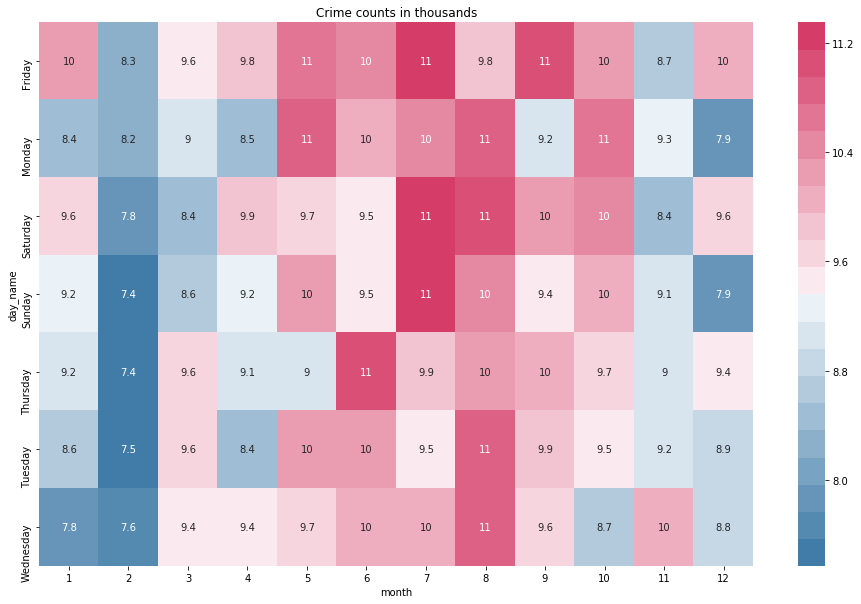

In [51]:
 #But when do arrests happen?
agg_month_dayname = agg_data.groupby(by=["month", "day_name"], as_index=False).sum()
agg_month_dayname["crime_count_1000s"] = agg_month_dayname["crime_count"] / 1000
heatmap_data = agg_month_dayname.pivot("day_name", "month", "crime_count_1000s")
col_palette = sns.diverging_palette(240, 1, n=20)
plt.figure(figsize=(16, 10))
plt.title("Crime counts in thousands")
g = sns.heatmap(data=heatmap_data, cmap=col_palette, annot=True)

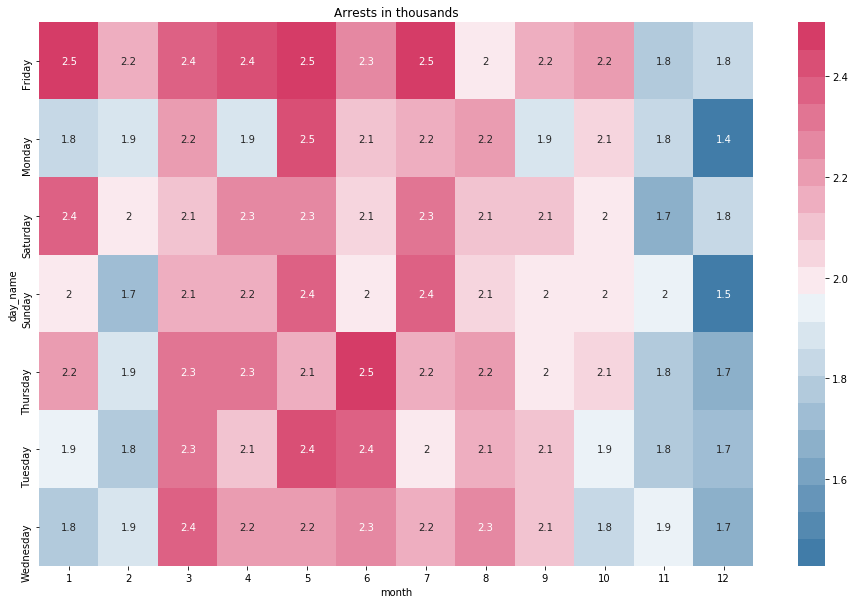

In [52]:
agg_month_dayname["arrest_1000s"] = agg_month_dayname["Arrest"] / 1000
heatmap_data = agg_month_dayname.pivot("day_name", "month", "arrest_1000s")
col_palette = sns.diverging_palette(240, 1, n=20)
plt.figure(figsize=(16, 10))
plt.title("Arrests in thousands")
g = sns.heatmap(data=heatmap_data, cmap=col_palette, annot=True)